In [7]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency
from statsmodels.stats.diagnostic import lilliefors

In [15]:
# Load measurements
older_adults_trial_level = pd.read_csv("../data/processed/older_adults/filtered_measurements.csv")
older_adults_average_level = pd.read_csv("../data/processed/older_adults/average_measurements.csv")

In [25]:
# Load additional information
additional_info = pd.read_csv("../data/raw/additional_participants_information.csv")
additional_info.head()

,participant name,gender,age,height,weight,foot length,foot width,faller,low stability
0,dida,female,79,156.0,67.0,28.0,11.5,0,0
1,ronald,male,80,176.0,89.0,32.0,12.0,0,0
2,inez,female,77,158.0,75.0,28.0,10.0,0,0
3,shalom,male,70,176.0,76.0,31.0,12.0,0,0
4,yaacov,male,73,169.0,96.0,29.0,10.5,0,0


In [26]:
df = additional_info

# Filter out students to keep older adults only
df = df[~df["participant name"].astype(str).str.isnumeric()]
df = df.drop(columns=["faller"])

# Groups
group_0 = df[df["low stability"] == 0]
group_1 = df[df["low stability"] == 1]

# Features to compare
numeric_vars = ["age", "height", "weight", "foot length", "foot width"]
results = []

for var in numeric_vars:
    values_0 = group_0[var].dropna()
    values_1 = group_1[var].dropna()

    # Normality
    _, p0 = lilliefors(values_0)
    _, p1 = lilliefors(values_1)
    normal_0 = p0 > 0.05
    normal_1 = p1 > 0.05

    # Test selection
    if normal_0 and normal_1:
        stat, pval = ttest_ind(values_0, values_1, equal_var=False)
        test_used = "t-test"
    else:
        stat, pval = mannwhitneyu(values_0, values_1, alternative='two-sided')
        test_used = "Mann-Whitney U"

    results.append({
        "Variable": var,
        "Non-Low Stability (Mean ± SEM)": f"{values_0.mean():.2f} ± {values_0.sem():.2f}",
        "Low Stability (Mean ± SEM)": f"{values_1.mean():.2f} ± {values_1.sem():.2f}",
        "Test Used": test_used,
        "P-Value": f"{pval:.4f}"
    })

# Gender (categorical)
female_0 = (group_0["gender"] == "female").sum()
male_0 = (group_0["gender"] == "male").sum()
female_1 = (group_1["gender"] == "female").sum()
male_1 = (group_1["gender"] == "male").sum()

# Chi-square
contingency = pd.crosstab(df["gender"], df["low stability"])
chi2, pval, _, _ = chi2_contingency(contingency)

results.append({
    "Variable": "gender (female / male)",
    "Non-Low Stability (Mean ± SEM)": f"{female_0} / {male_0}",
    "Low Stability (Mean ± SEM)": f"{female_1} / {male_1}",
    "Test Used": "Chi-Square",
    "P-Value": f"{pval:.4f}"
})

# Convert to DataFrame
summary_df = pd.DataFrame(results)
summary_df

,Variable,Non-Low Stability (Mean ± SEM),Low Stability (Mean ± SEM),Test Used,P-Value
0,age,75.90 ± 0.99,73.30 ± 1.57,Mann-Whitney U,0.0871
1,height,164.60 ± 1.55,163.40 ± 3.42,t-test,0.7544
2,weight,71.83 ± 2.41,77.10 ± 3.12,t-test,0.1957
3,foot length,28.62 ± 0.39,28.35 ± 0.70,t-test,0.7444
4,foot width,11.05 ± 0.21,10.85 ± 0.33,t-test,0.6137
5,gender (female / male),15 / 15,6 / 4,Chi-Square,0.8550


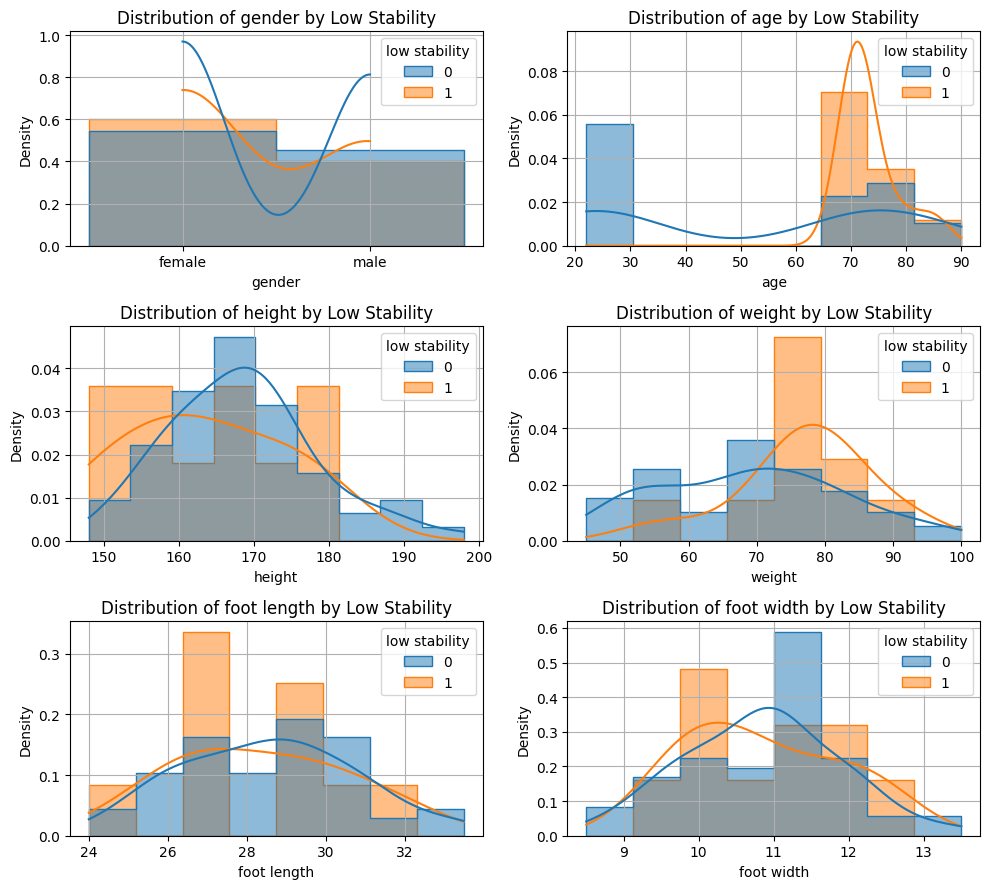

In [31]:
df = additional_info

# Drop irrelevant columns
df = df.drop(columns=["participant name", "faller"])

# Set up the plotting
features = df.columns.drop("low stability")
num_features = len(features)
fig, axes = plt.subplots(nrows=(num_features + 1) // 2, ncols=2, figsize=(10, 3 * ((num_features + 1) // 2)))
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(features):
    ax = axes[i]
    sns.histplot(data=df, x=feature, hue="low stability", kde=True, element="step", stat="density", common_norm=False, alpha=0.5, ax=ax)
    ax.set_title(f"Distribution of {feature} by Low Stability")
    ax.grid(True)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()